In [1]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

import pyprob
import pyprob.distributions

from PIL import Image, ImageFilter, ImageDraw, ImageFont


In [153]:
alphabetorder = list('abcdefghijklmnopqrstuvw')
alphabet = dict(zip(range(len(alphabetorder)),alphabetorder))
def message_to_picture(width, height, message, blur):
    canvas = Image.new('L', (width, height), "white")
    font = ImageFont.load_default()
    ImageDraw.Draw(canvas).text((2,0), message, 'black', font)
    canvas = canvas.filter(ImageFilter.GaussianBlur(blur))
    d = np.asarray(list(canvas.getdata()), dtype = np.float)
    return d

def random_captcha(width, height, blur = 0.5):
    letter_distr = pyprob.distributions.Categorical([1/len(alphabet)]*len(alphabet))
    length = 3
    word =  ''.join([alphabet[letter_distr.sample().item()] for i in range(length)])
    d = message_to_picture(width, height, word,blur)
    return word, torch.tensor(d, dtype = torch.float).view(-1)/255-0.5

def likelihoood(observation,eps):
    lhood = pyprob.distributions.Normal(observation,eps*torch.ones(observation.shape))
    return lhood

In [50]:
rescaled = random_captcha(20,12)[1]
rescaled.shape

torch.Size([240])

kap


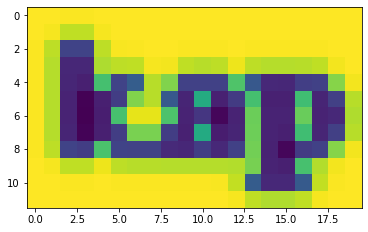

In [51]:
word, img = random_captcha(20,12)
print(word)
plt.imshow(img.reshape(12,20))

In [126]:
import math
import pyprob
from pyprob import Model
from pyprob.distributions import Normal

class CaptchaModel(Model):
    def __init__(self):
        super().__init__(name="Gaussian with unknown mean") # give the model a name

    def forward(self): # Needed to specifcy how the generative model is run forward
        mu = pyprob.sample(pyprob.distributions.Normal(0,1))
        word, d = random_captcha(20,12, blur = 0.5)
        obs_distr = likelihoood(d,1.0)
        pyprob.observe(pyprob.distributions.Normal(d,0.5*torch.ones(d.shape)), name = 'obs0')
        return word, d

model = CaptchaModel()

In [129]:
model.learn_inference_network(
    num_traces=1000,
    observe_embeddings={'obs0': {'dim': 32, 'depth': 3}}
)

Continuing to train existing inference network...
Total number of parameters: 59,887
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Traces/sec
0d:00:00:08 | 1    | 8,448     | +1.32e+00 | +1.21e+00 | +1.38e+00 | 0d:00:00:01 | 985.0  


Time spent  | Time remain.| Progress             | Trace | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 10/10 | 952.90       


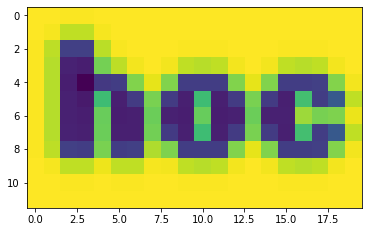

In [130]:
prior = model.prior_distribution()
condition = prior.sample()
plt.imshow(condition[1].numpy().reshape(12,-1))

In [131]:
posterior = model.posterior_distribution(
    num_traces=10000,
    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK,
    observe={'obs0': condition[1].numpy()}
)

Time spent  | Time remain.| Progress             | Trace       | Traces/sec
0d:00:00:24 | 0d:00:00:00 | #################### | 10000/10000 | 400.12       


0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


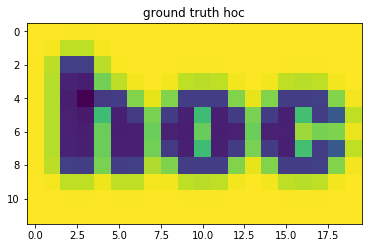

In [184]:
for i in range(100):
    if i%5 == 0: print(i)
    plt.imshow(posterior.sample()[1].reshape(12,-1))
    plt.title('ground truth {}'.format(condition[0]))
    plt.savefig('foranim{}.png'.format(str(i).zfill(6)))
#     plt.show()

In [185]:
!convert -delay 5 -loop 0 foranim*.png anim.gif

In [186]:
!open -a Safari anim.gif

In [135]:
!open anim.gif

0


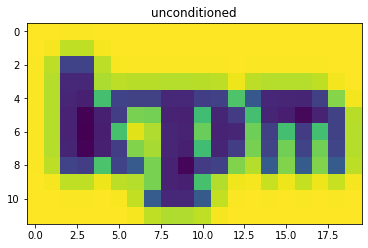

1


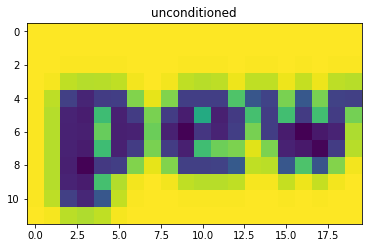

2


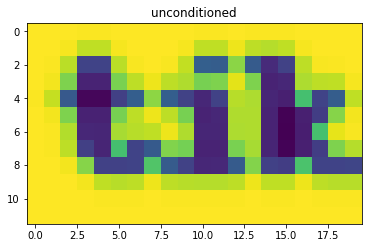

3


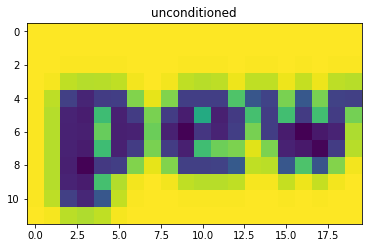

4


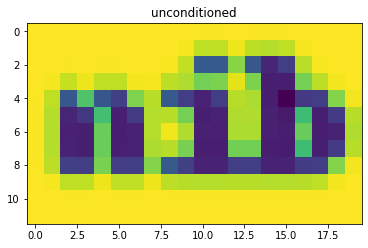

5


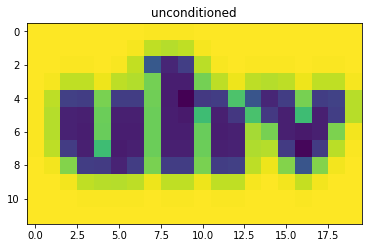

6


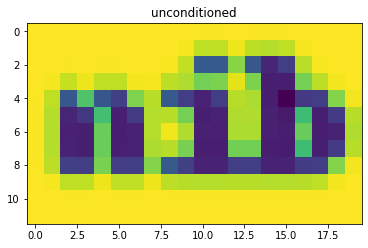

7


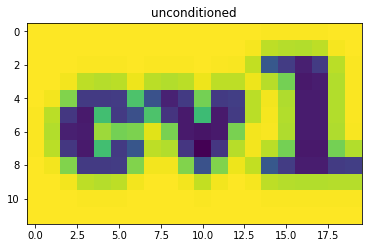

8


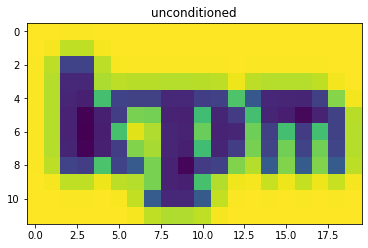

9


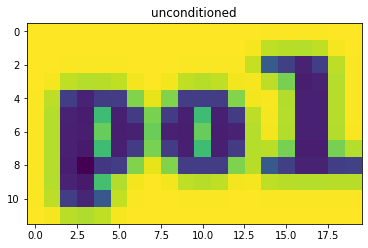

10


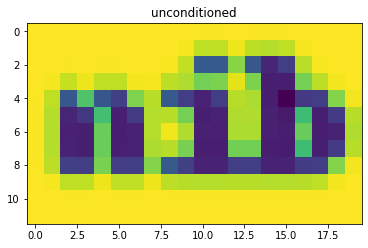

11


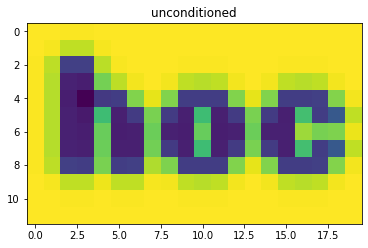

12


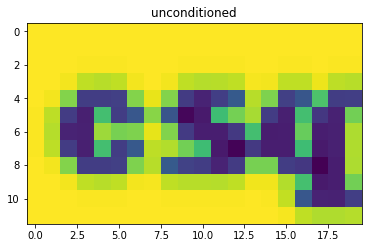

13


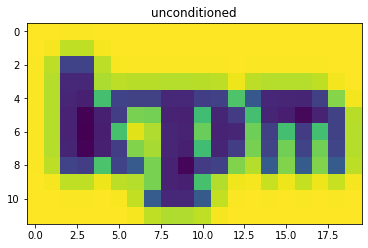

14


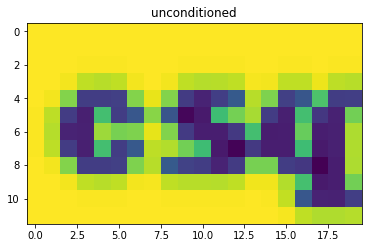

15


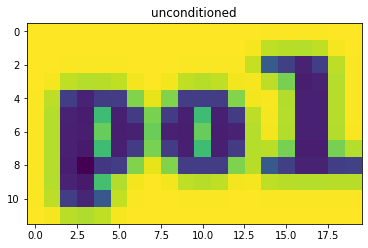

16


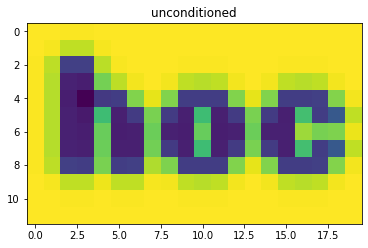

17


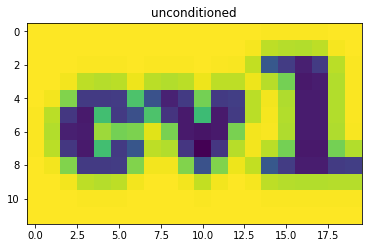

18


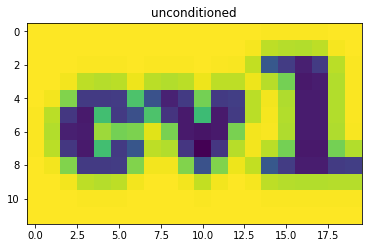

19


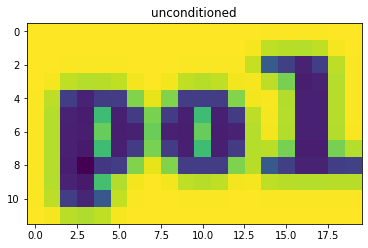

20


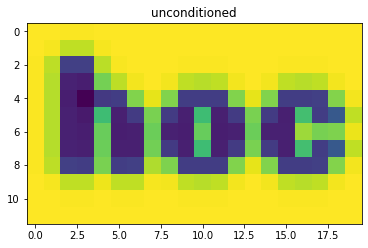

21


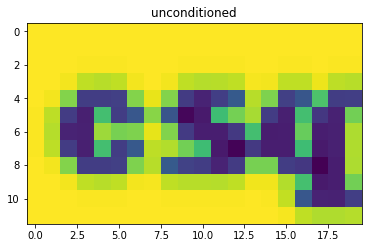

22


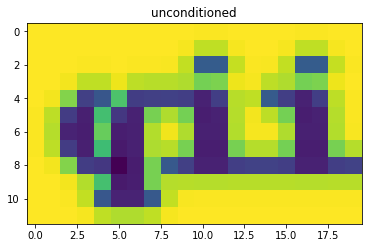

23


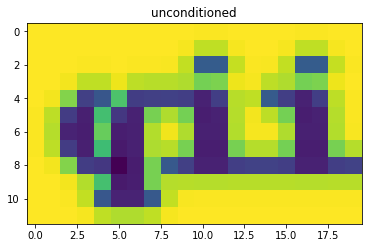

24


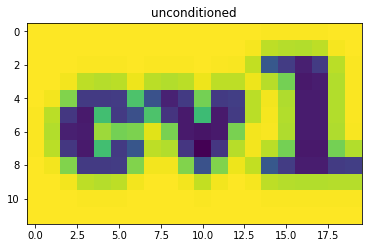

25


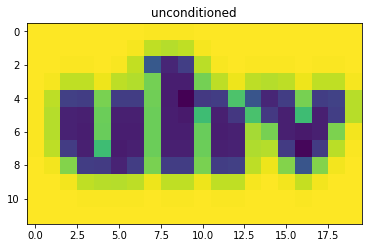

26


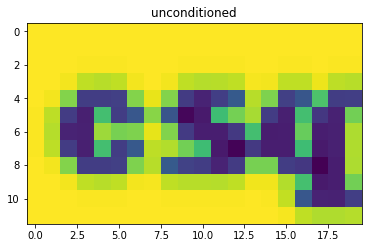

27


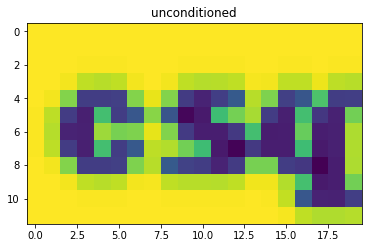

28


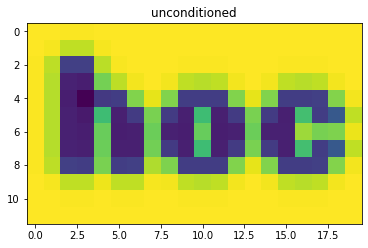

29


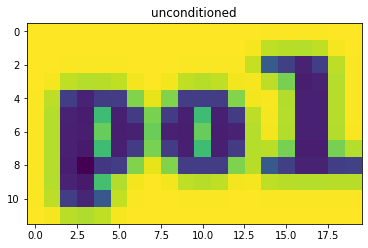

30


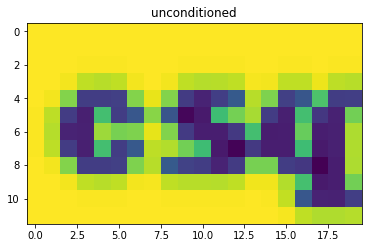

31


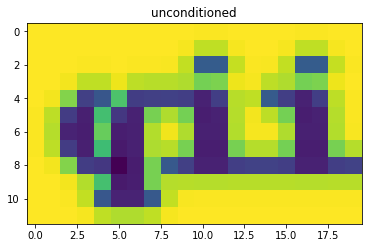

32


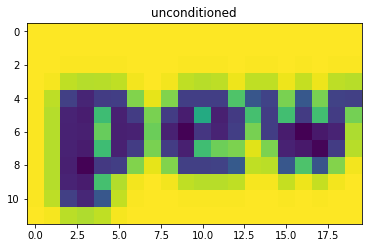

33


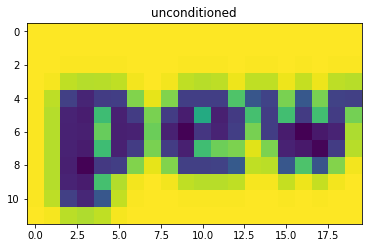

34


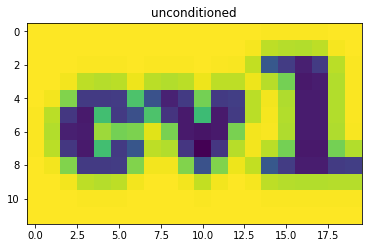

35


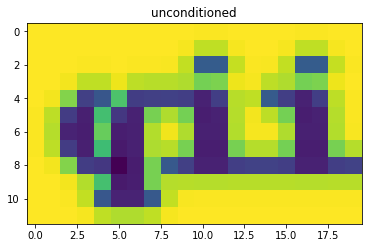

36


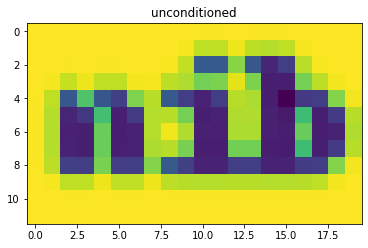

37


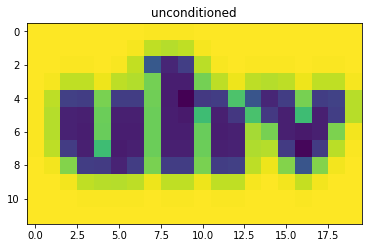

38


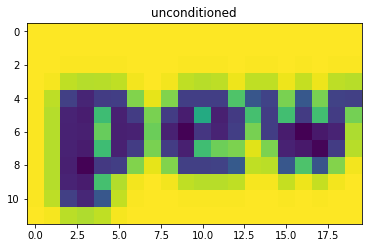

39


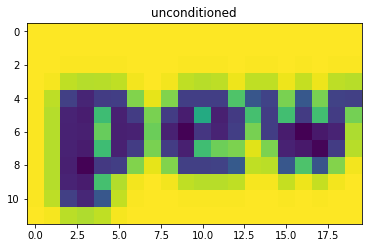

40


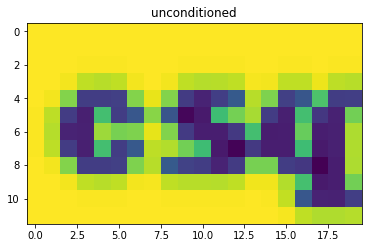

41


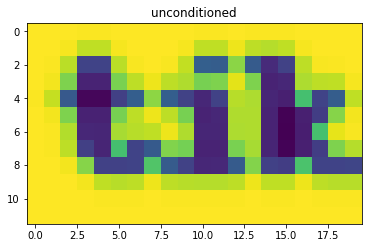

42


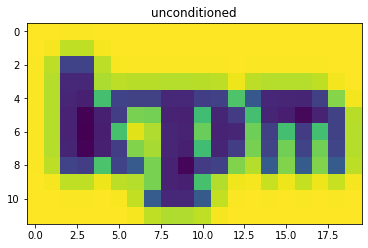

43


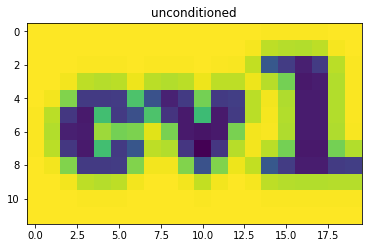

44


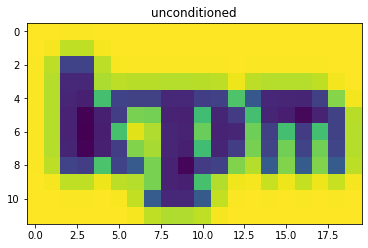

45


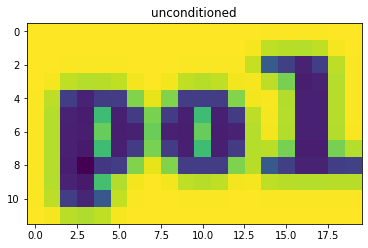

46


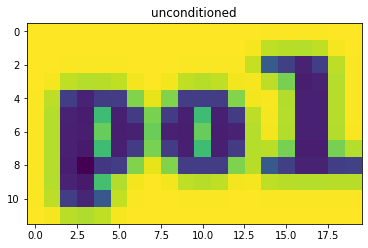

47


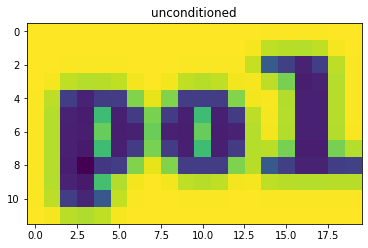

48


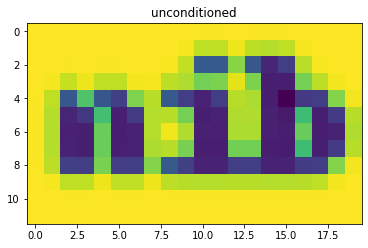

49


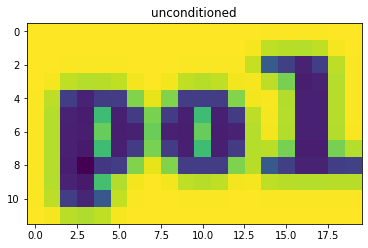

50


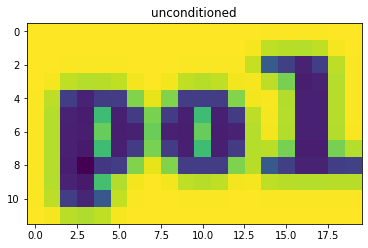

51


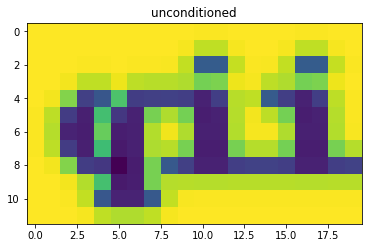

52


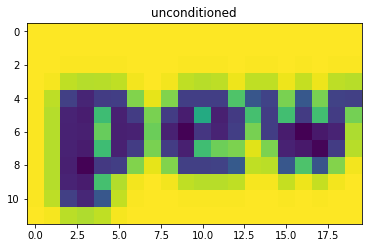

53


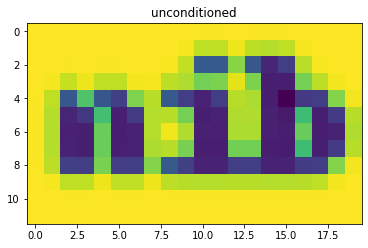

54


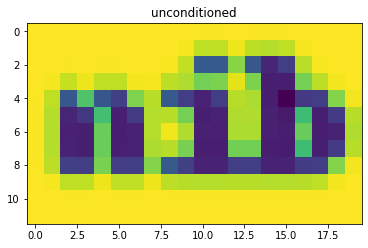

55


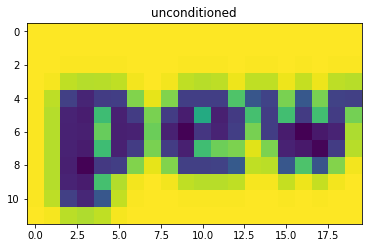

56


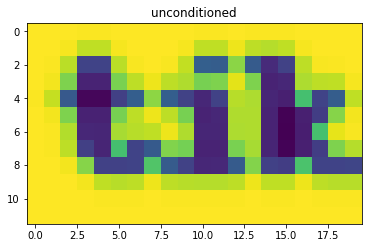

57


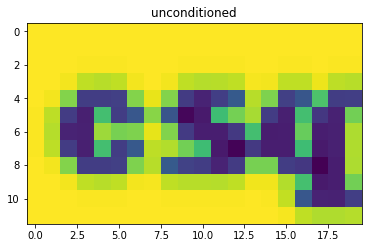

58


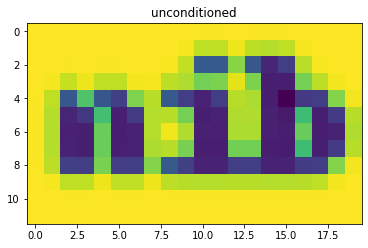

59


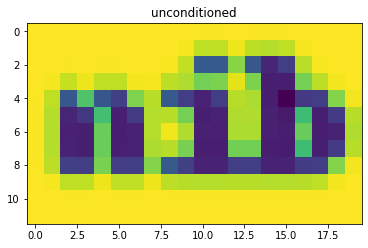

60


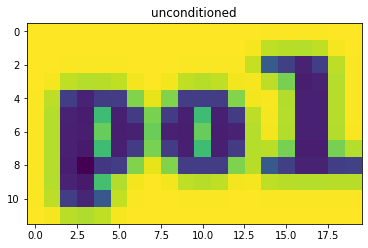

61


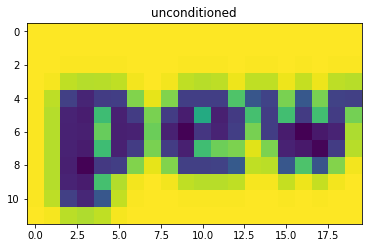

62


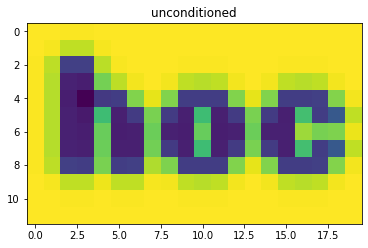

63


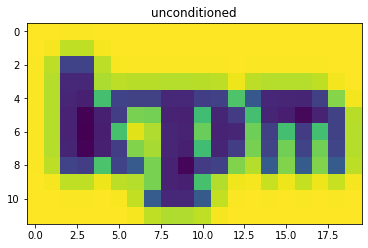

64


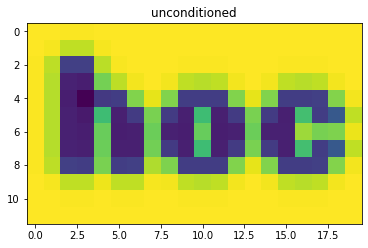

65


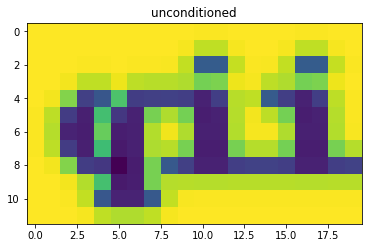

66


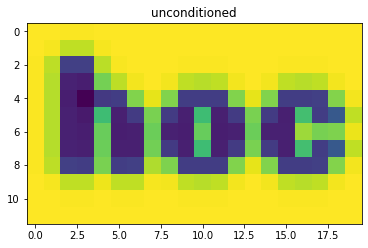

67


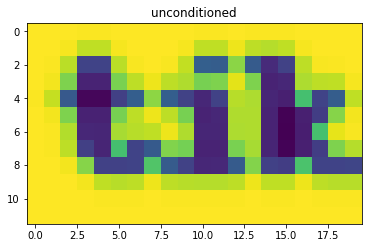

68


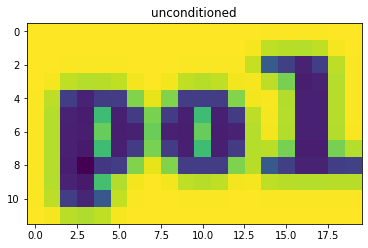

69


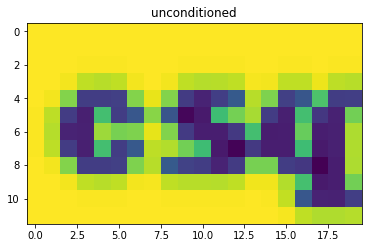

70


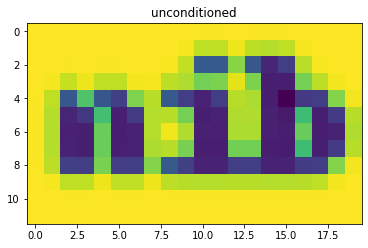

71


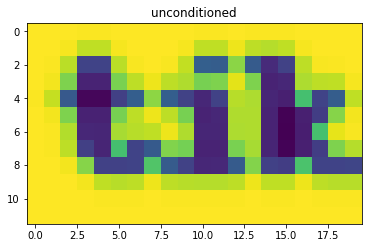

72


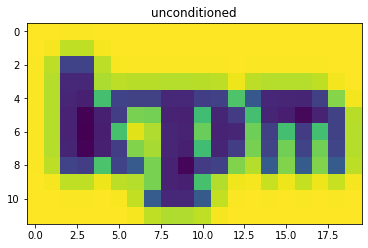

73


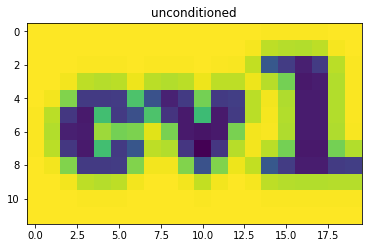

74


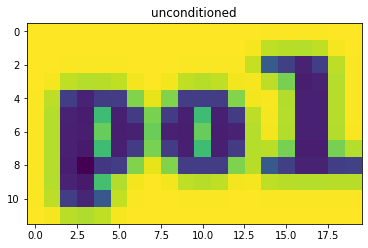

75


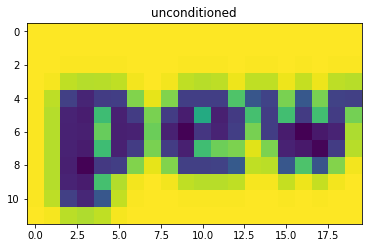

76


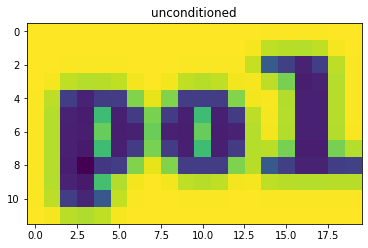

77


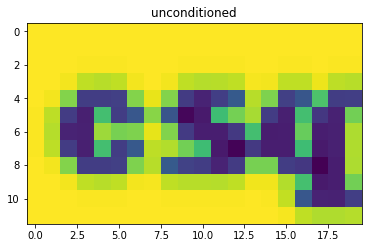

78


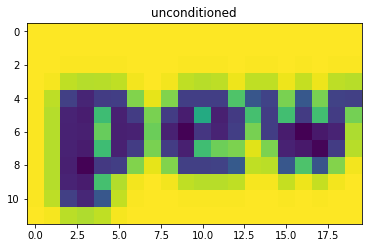

79


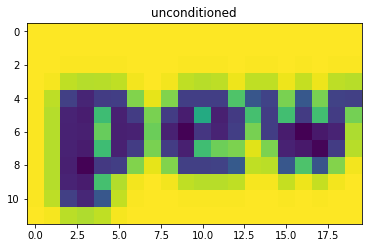

80


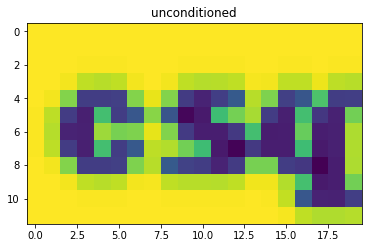

81


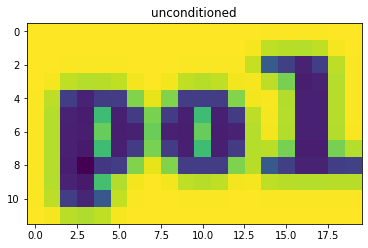

82


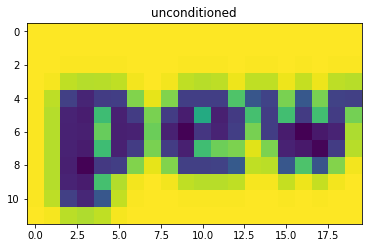

83


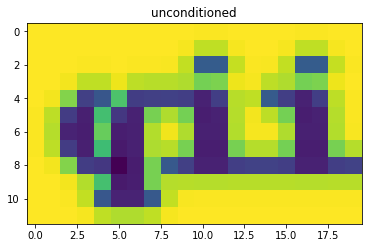

84


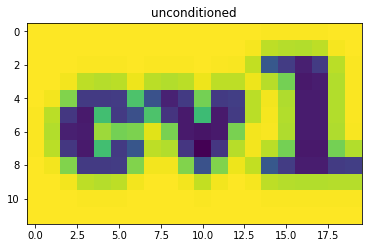

85


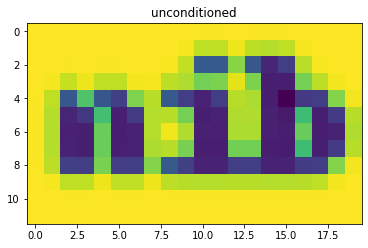

86


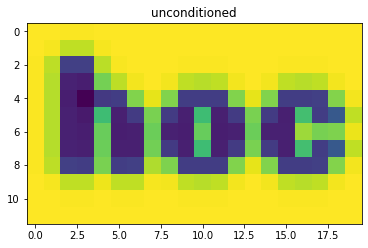

87


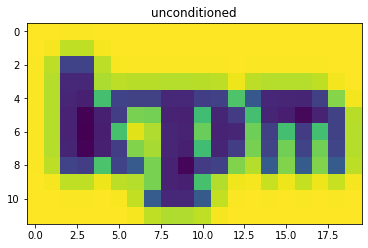

88


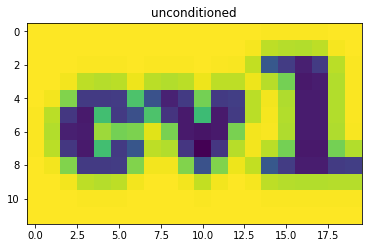

89


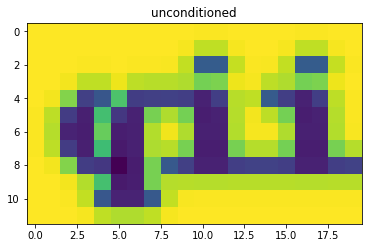

90


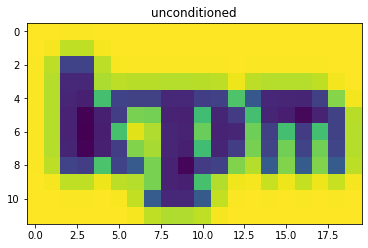

91


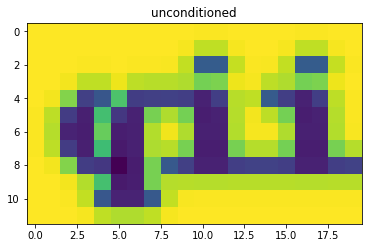

92


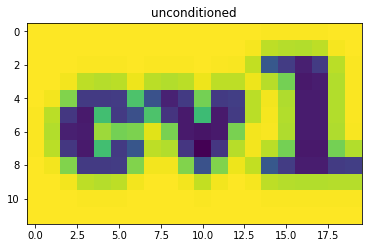

93


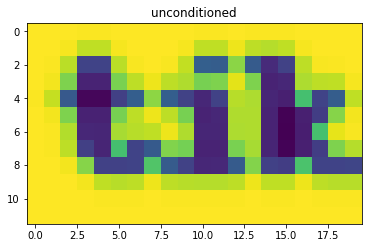

94


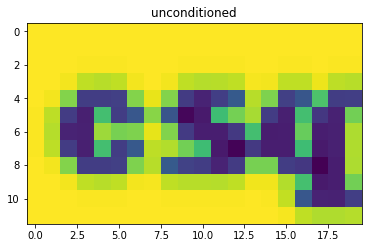

95


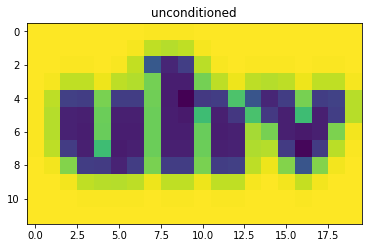

96


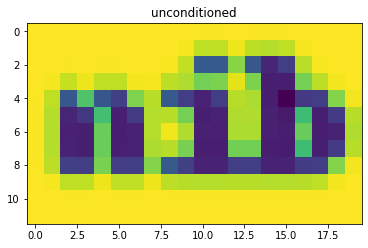

97


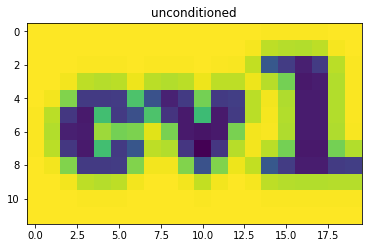

98


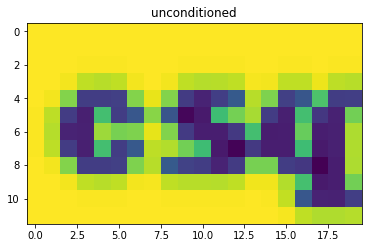

99


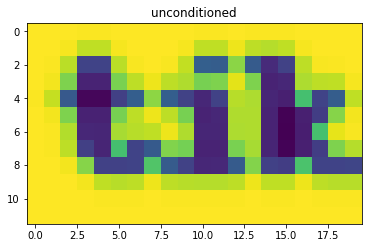

In [136]:
for i in range(100):
    print(i)
    plt.imshow(prior.sample()[1].reshape(12,-1))
    plt.title('unconditioned')
    plt.savefig('foranim{}.png'.format(str(i).zfill(6)))
    plt.show()
!convert -delay 5 -loop 0 foranim*.png prior.gif

In [137]:
!open -a Safari anim.gif

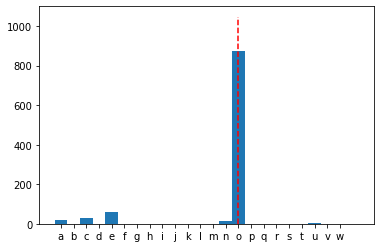

In [205]:
letter_num = 1

reverse_alphabet = {v:k for k,v in alphabet.items()} 
c,_,_ = plt.hist([reverse_alphabet[posterior.sample()[0][letter_num]] for i in range(1000)], bins = np.linspace(-0.5,len(alphabet)+0.5,len(alphabet)+2))

plt.xticks(range(len(alphabetorder)),list(alphabetorder));
plt.vlines(reverse_alphabet[condition[0][letter_num]],0,1.2*max(c), colors = 'r', linestyles = 'dashed')

In [206]:
solutions, counts = np.unique([posterior.sample()[0] for i in range(100)], return_counts = True)
solutions[np.argmax(counts)]

'hoc'